<span style="font-size:25px">___ATENCIÓN!!___ El presente documento se ha hecho con la intención de mostrar de algna manera el trabajo que ha habido detrás de las decisiones finales tomadas. Sin embargo, el proceso no se ha llevado a cabo en el mismo orden en que se presenta el presete documento. Aunque en este _notebook_ se han llevado a cabo unas pocas iteraciones, la realidad es que se han hecho muchas más, tras las cuales normalmente se ha vuelto a la fase de análisis de datos y a intentar enriquecer los datos para mejorar los modelos.</span>

# Pruebas entrenamientos de modelos

En el presente documento se presentan las diferentes pruebas que se han hecho en para encontrar el modelo que mejores predicciones nos ofrezca a partir de los datos con los que contamos.

In [1]:
## Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Para el cálculo de distancias entre apartamentos y medios de transporte
from geopy.distance import distance
from decimal import *
## Librerías para el entrenamiento del modelo
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

In [2]:
# Importamos data set
df = pd.read_csv('../data/df_pruebas_modelos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12637 entries, 0 to 12636
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    12637 non-null  int64  
 1   neighbourhood_group_cleansed  12637 non-null  object 
 2   bathrooms                     12637 non-null  int64  
 3   bedrooms                      12637 non-null  int64  
 4   price                         12637 non-null  float64
 5   neighbourhood_scale           12637 non-null  float64
 6   neighbourhood_num             12637 non-null  int64  
 7   terraza                       12637 non-null  int64  
 8   balcon                        12637 non-null  int64  
 9   calefaccion                   12637 non-null  int64  
 10  pool                          12637 non-null  int64  
 11  garaje                        12637 non-null  int64  
 12  aire_acondicionado            12637 non-null  int64  
 13  a

## Modelo 1

En esta primera iteración, probaremos a entrenar modelos de regresión lineal con el total del _data-set_ para después comprobar el modelo que dé mejores resultados y ver cuáles son las variables que más afectan en las predicciones de __precio/noche__.

En primer lugar, dividimos el _data-set_ en 80% como conjunto de entrenamiento y 20% como conjunto de valización, dejando la variable _price_ como _target_.

In [3]:
target = "price"
y,X =df[target], df.drop(target,axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

Normalizamos el DS utilizando _StandardScaler_ y convertimos las variables no-numérica en variables numéricas con _OneHotEncoder_.

In [4]:
numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

### Elección del modelo

Comprobamos diferentes modelos de regresión para ver cuáles son los más idóneos.

In [16]:
# models = {"lr":LinearRegression(),
#           "ridge":Ridge(alpha=0),
#           "lasso":Lasso(),
#           "SGD":SGDRegressor(),
#           "HuberRegressor":HuberRegressor(),
#           "Elastic":ElasticNet(),
#           "XGBRegressor":XGBRegressor(),
#           "SVR":SVR()}

models = {
    'LinearRegression': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', LinearRegression())]),
    'Ridge': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Ridge(alpha=1, random_state=42))]),
    'Lasso': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Lasso(alpha=1, random_state=42))]),
    'SGD': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', SGDRegressor(alpha=0.0001, max_iter=1000, random_state=42))]),
    'HuberRegressor': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', HuberRegressor(alpha=0.0001, max_iter=100, epsilon=1.35))]),
    'ElasticNet': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', ElasticNet(alpha=1, l1_ratio=0.5, random_state=42))]),
    'XGBRegressor': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))]),
    'SVR': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', SVR(kernel='linear'))])
}

def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
        df_metrics_analysis = pd.DataFrame(metrics_analysis).sort_values('mape')
    return df_metrics_analysis

In [17]:
get_results(X_train, y_train, X_test, y_test)

 38%|███▊      | 3/8 [00:00<00:00,  5.33it/s]c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


,r2,mse,rmse,mape
SVR,0.405240,1292.459770,35.950797,0.240057
HuberRegressor,0.413213,1275.133593,35.709013,0.242677
XGBRegressor,0.460291,1172.829852,34.246604,0.245609
LinearRegression,0.414745,1271.805403,35.662381,0.255940
Ridge,0.414704,1271.894379,35.663628,0.255968
SGD,0.406451,1289.828966,35.914189,0.259882
Lasso,0.390217,1325.105703,36.402001,0.268854
ElasticNet,0.374379,1359.523097,36.871711,0.276899


In [18]:
# model = SVR(kernel='linear', C=1.0, epsilon=0.1)
# reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
# reg_cv.fit(X_train, y_train)
param_grid = {
    'regressor__C': [0.1, 1.0, 10.0],
    'regressor__epsilon': [0.1, 0.2, 0.3]
}

pipe = models['SVR']

grid_search = GridSearchCV(pipe, param_grid, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'neighbourhood_scale',
                                                                          'neighbourhood_num',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to...
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin',
                                                                          'DISTANCE_TO_METRO',
                                                                          'DISTANCE_TO_CERCANIAS',
                                                                          'DISTANCE_TO_EMT',
                                                                          'DISTANCE_TO_INTERURBANOS',
                                                                          'DISTANCE_TO_MLO']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['neighbourhood_group_cleansed',
                                                                          'renta_bin'])])),
                                       ('regressor', SVR(kernel='linear'))]),
             param_grid={'regressor__C': [0.1, 1.0, 10.0],
                         'regressor__epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [19]:
# model = SVR(**reg_cv.best_params_)
# model.fit(X_train,y_train)
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

In [20]:
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [21]:
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.40215165198112457 mse: 1377.7537508385817 rmse: 37.1181054316971 mape: 0.23947240888372542


In [22]:
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4115182120992088 mse: 1278.8168442617086 rmse: 35.76054871309595 mape: 0.23806831713961743


In [23]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

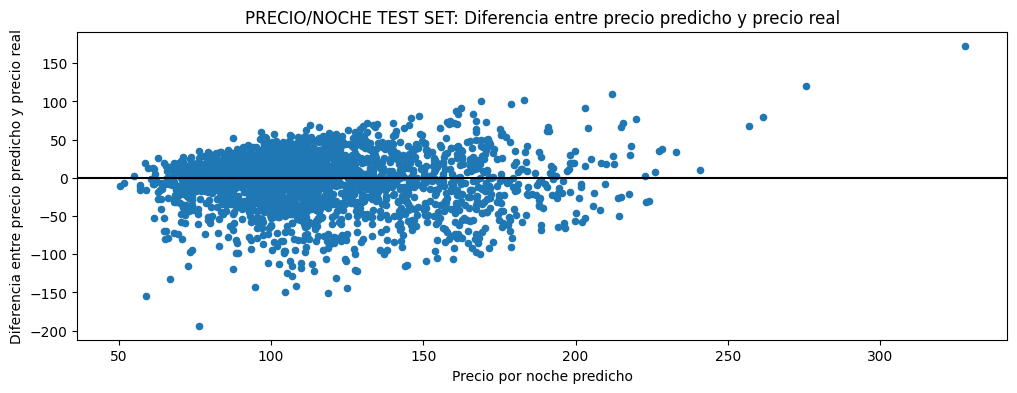

In [24]:
_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")

In [25]:
# 🔍 Obtenemos los nombres de columnas transformadas:
# Para numéricas, los nombres se mantienen
num_names = numerical_features

# Para categóricas, necesitamos obtenerlos desde el OneHotEncoder
cat_names = best_model.named_steps["preprocessor"].named_transformers_['cat'].get_feature_names_out(categorical_features)

# # Combinamos ambos
all_feature_names = list(num_names) + list(cat_names)

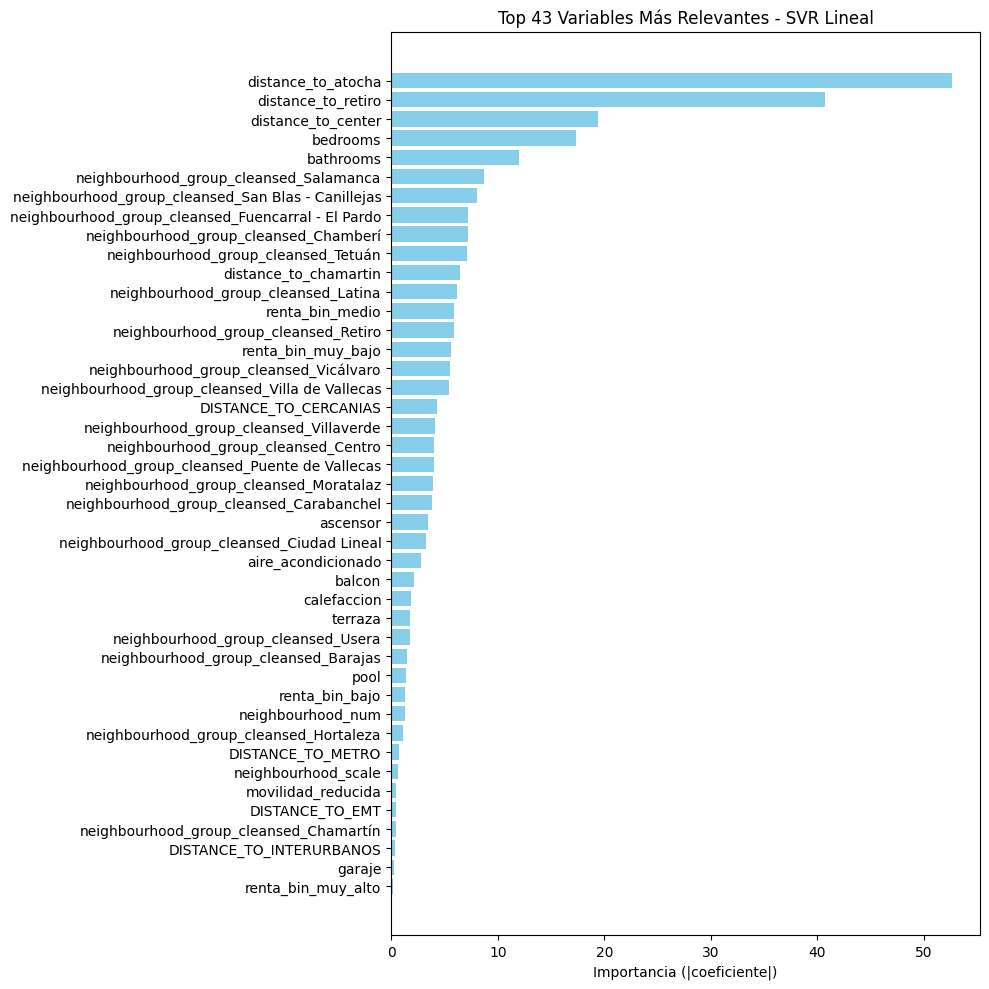

In [26]:
# Extraer los coeficientes absolutos
coeficientes = np.abs(best_model.named_steps['regressor'].coef_[0])

# Asociar coeficientes con nombres de variables
importancias_df = pd.DataFrame({
    'Variable': all_feature_names,
    'Importancia': coeficientes
}).sort_values(by='Importancia', ascending=False)

# Opcional: filtrar top N variables más importantes
top_n = 43
importancias_top = importancias_df.head(top_n)

# Graficar
plt.figure(figsize=(10, 10))
plt.barh(importancias_top['Variable'], importancias_top['Importancia'], color='skyblue')
plt.gca().invert_yaxis()  # Las más importantes arriba
plt.xlabel('Importancia (|coeficiente|)')
plt.title(f'Top {top_n} Variables Más Relevantes - SVR Lineal')
plt.tight_layout()
plt.show()